In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import heapq

/home/ohara_lab/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
n_train_data = train.shape[0]

In [3]:
submission = pd.read_csv('../input/sample_submission.csv')
seg_id = submission['seg_id']
n_test = len(seg_id)

In [4]:
n_train_data = train.shape[0]

In [5]:
test0 = pd.read_csv('../input/test/' + seg_id[0] + '.csv')
n_test_data = test0.shape[0]

In [6]:
seg_n = n_test_data
n_train = int(np.floor(train.shape[0] / seg_n))
n_train

4194

In [8]:
n_train_mod = train.shape[0] % seg_n
n_train_mod

45480

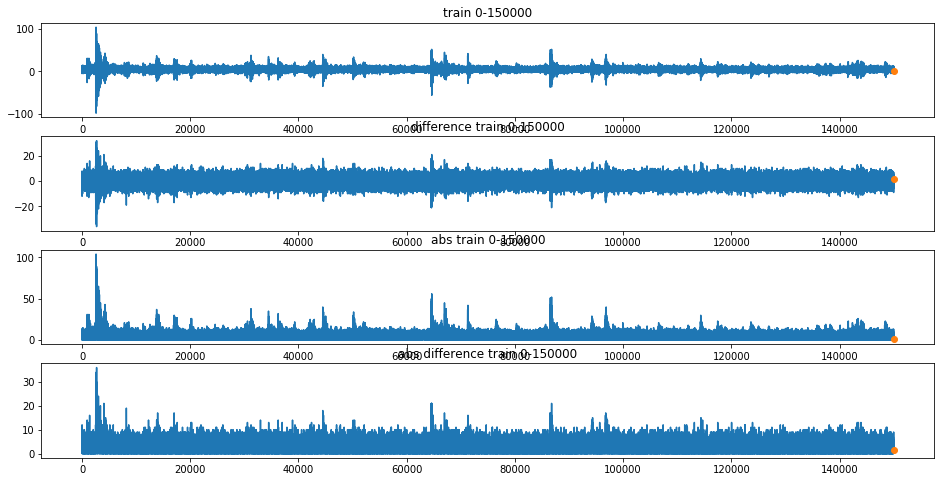

In [30]:
plt.subplots(figsize=(16, 8))

plt.subplot(4, 1, 1)
plt.title('train 0-'+str(seg_n))
plt.plot(train['acoustic_data'][:seg_n])
plt.plot(seg_n-1, train['time_to_failure'][seg_n-1], 'o')

plt.subplot(4, 1, 2)
plt.title('difference train 0-'+str(seg_n))
plt.plot(np.diff(train['acoustic_data'][:seg_n], axis=0))
plt.plot(seg_n-1, train['time_to_failure'][seg_n-1], 'o')

plt.subplot(4, 1, 3)
plt.title('abs train 0-'+str(seg_n))
plt.plot(np.abs(train['acoustic_data'][:seg_n]))
plt.plot(seg_n-1, train['time_to_failure'][seg_n-1], 'o')

plt.subplot(4, 1, 4)
plt.title('abs difference train 0-'+str(seg_n))
plt.plot(np.abs(np.diff(train['acoustic_data'][:seg_n], axis=0)))
plt.plot(seg_n-1, train['time_to_failure'][seg_n-1], 'o')

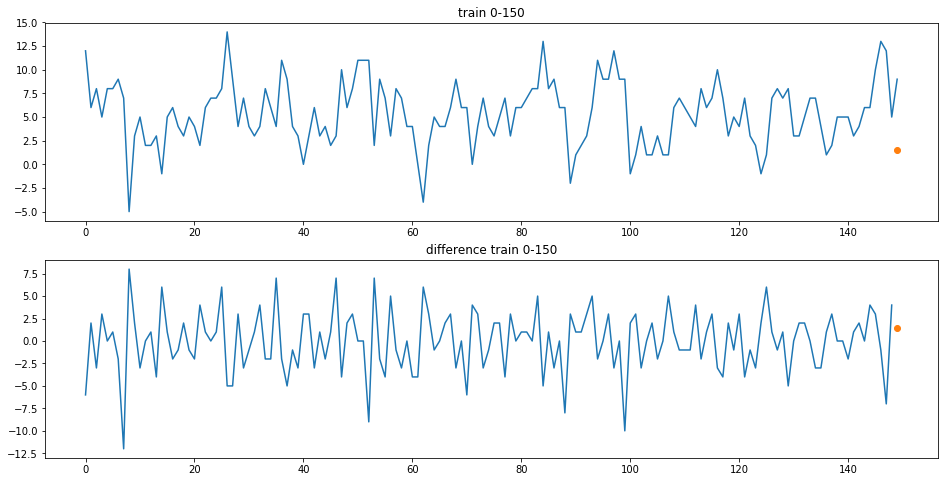

In [9]:
plt.subplots(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title('train 0-'+str(int(seg_n/1000)))
plt.plot(train['acoustic_data'][:int(seg_n/1000)])
plt.plot(int(seg_n/1000)-1, train['time_to_failure'][int(seg_n/1000)-1], 'o')

plt.subplot(2, 1, 2)
plt.title('difference train 0-'+str(int(seg_n/1000)))
plt.plot(np.diff(train['acoustic_data'][:int(seg_n/1000)], axis=0))
plt.plot(int(seg_n/1000)-1, train['time_to_failure'][int(seg_n/1000)-1], 'o')

In [11]:
p = int(np.floor(n_train*0.01))
p

41

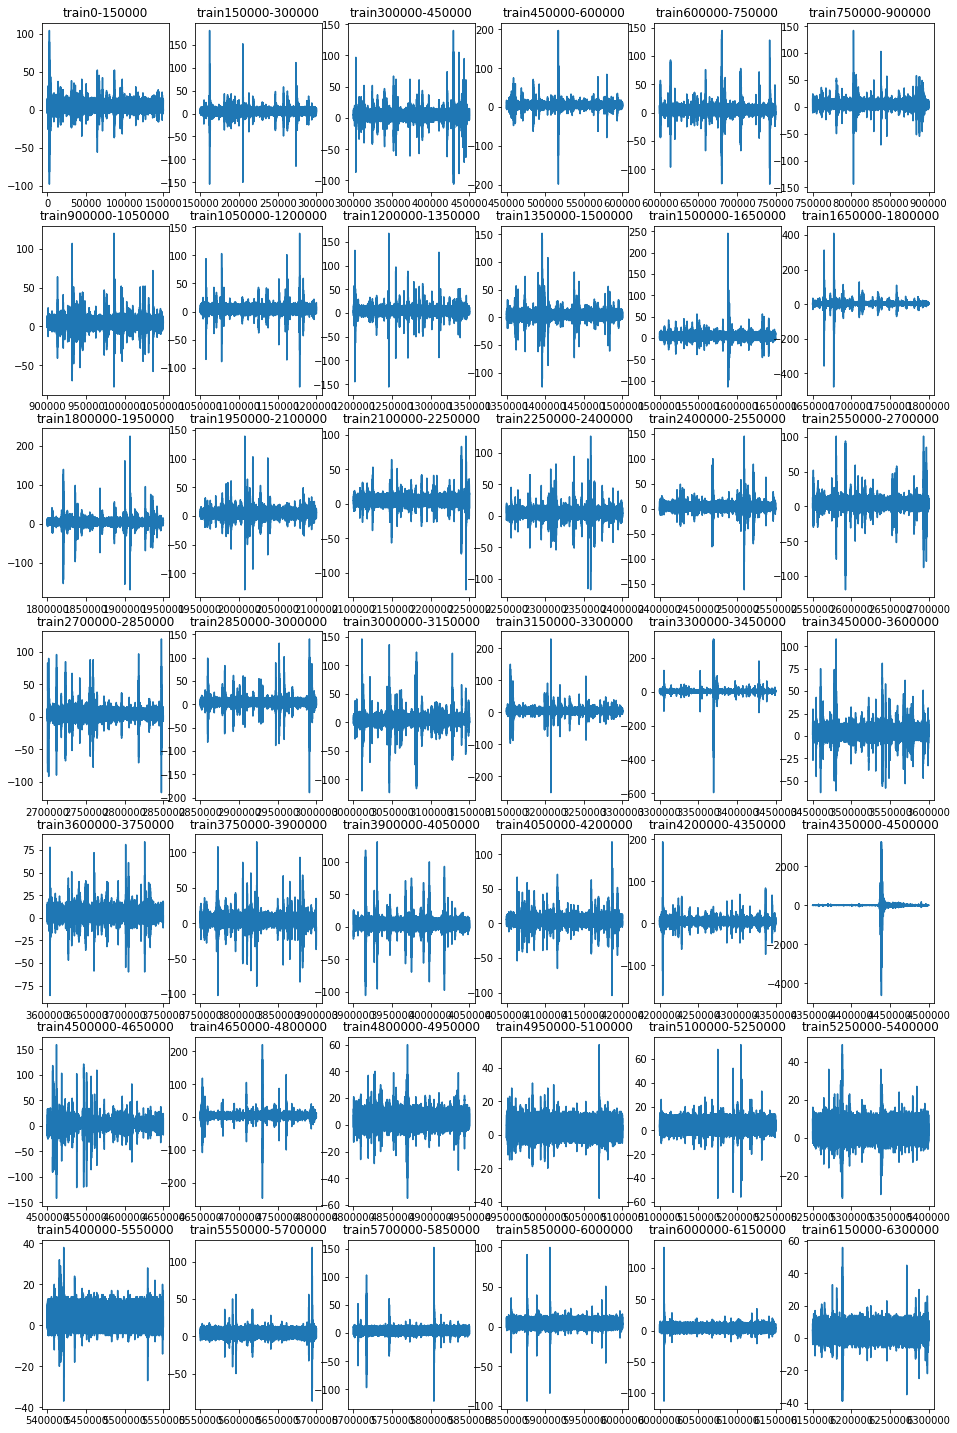

In [12]:
plt.subplots(figsize=(16,22))
for i in range(p+1):
    plt.subplot(7, 6, i+1)
    plt.plot(train['acoustic_data'][i*seg_n:(i+1)*seg_n])
    plt.title('train'+str(i*seg_n)+'-'+str((i+1)*seg_n))
plt.subplots_adjust(top=1)

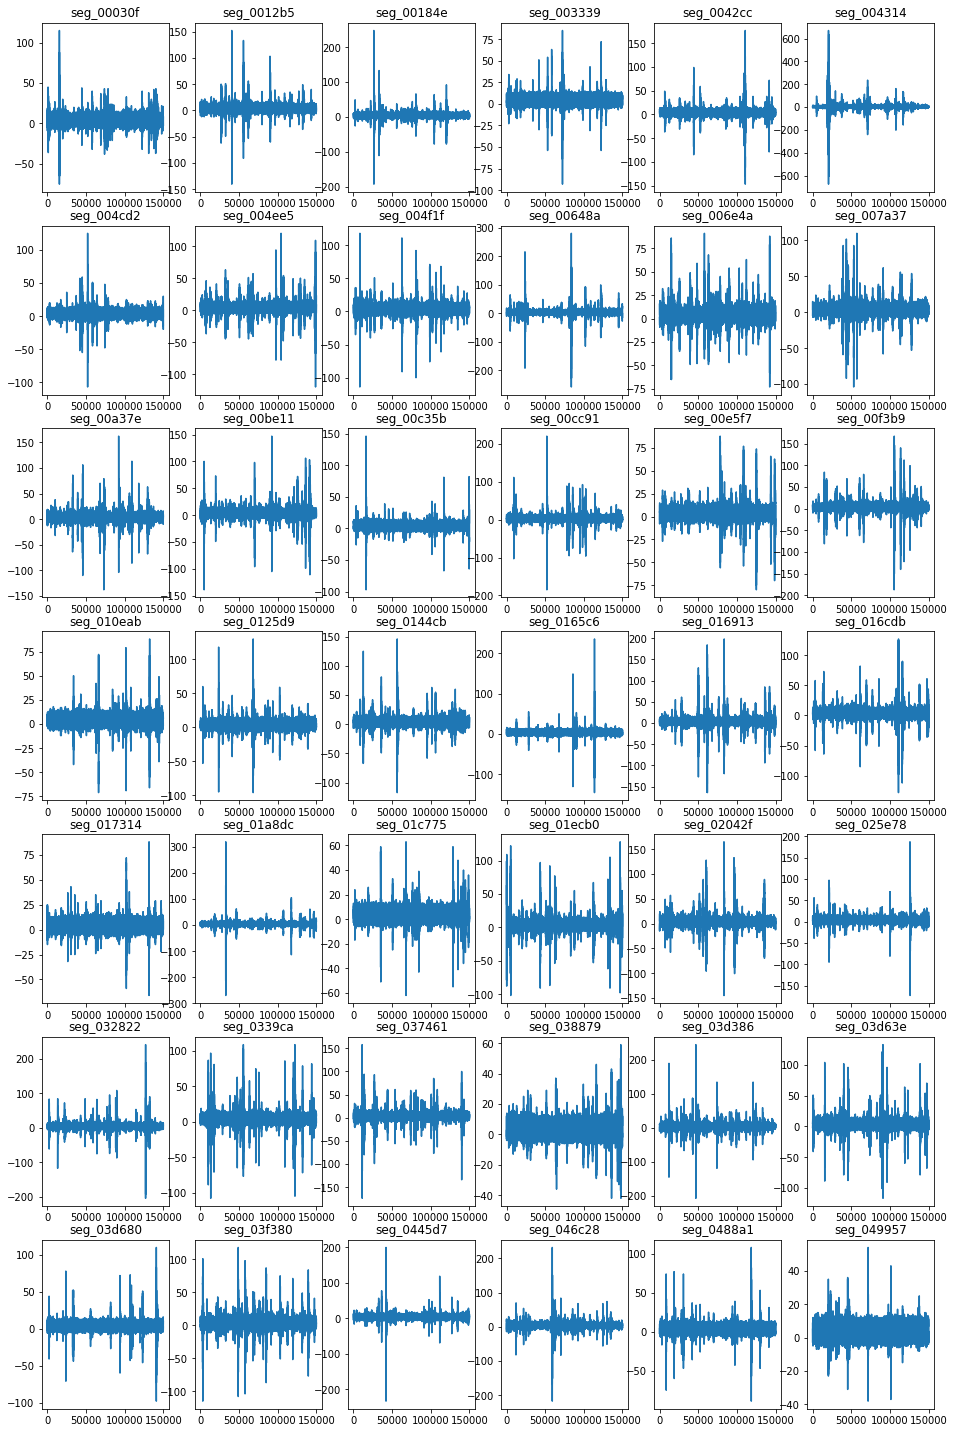

In [13]:
plt.subplots(figsize=(16,22))
for i in range(p+1):
    testi = pd.read_csv('../input/test/' + seg_id[i] + '.csv')
    plt.subplot(7, 6, i+1)
    plt.plot(testi['acoustic_data'])
    plt.title(str(seg_id[i]))
plt.subplots_adjust(top=1)

In [65]:
column = [
          'mean', 'var', 'skew', 'kurt', 'mad', 'comp',
          'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
          'aq1', 'aq2', 'aq3', 'aq4', 'aq5', 'aq6', 'aq7', 'aq8', 'aq9',
          'diff_mean', 'diff_var', 'diff_skew', 'diff_kurt', 'diff_mad', 'diff_comp',
          'diff_mean10_1', 'diff_mean10_2', 'diff_mean10_3', 'diff_mean10_4', 'diff_mean10_5', 
          'diff_mean10_6', 'diff_mean10_7', 'diff_mean10_8', 'diff_mean10_9', 'diff_mean10_10',
          'diff_var10_1', 'diff_var10_2', 'diff_var10_3', 'diff_var10_4', 'diff_var10_5',
          'diff_var10_6', 'diff_var10_7', 'diff_var10_8', 'diff_var10_9', 'diff_var10_10',
          'diff_skew10_1', 'diff_skew10_2', 'diff_skew10_3', 'diff_skew10_4', 'diff_skew10_5',
          'diff_skew10_6', 'diff_skew10_7', 'diff_skew10_8', 'diff_skew10_9', 'diff_skew10_10',
          'diff_kurt10_1', 'diff_kurt10_2', 'diff_kurt10_3', 'diff_kurt10_4', 'diff_kurt10_5',
          'diff_kurt10_6', 'diff_kurt10_7', 'diff_kurt10_8', 'diff_kurt10_9', 'diff_kurt10_10',
          'diff_mad10_1', 'diff_mad10_2', 'diff_mad10_3', 'diff_mad10_4', 'diff_mad10_5',
          'diff_mad10_6', 'diff_mad10_7', 'diff_mad10_8', 'diff_mad10_9', 'diff_mad10_10',
          'diff_comp10_1', 'diff_comp10_2', 'diff_comp10_3', 'diff_comp10_4', 'diff_comp10_5',
          'diff_comp10_6', 'diff_comp10_7', 'diff_comp10_8', 'diff_comp10_9', 'diff_comp10_10'
          ]

In [67]:
X_train = pd.DataFrame(index = range(n_train), columns= column)
y_train = pd.DataFrame(index = range(n_train), columns = ['time_to_failure'])

In [68]:
X_test = pd.DataFrame(index = range(n_test), columns = column)

In [69]:
# for j in range(n_train_mod):
for i in range(n_train):
    if i % 100 == 0:
        print(i)
#     train_seg = train.iloc[j+i*seg_n:j+(i+1)*seg_n]
    train_seg = train.iloc[i*seg_n:(i+1)*seg_n]
    train_seg_diff = pd.DataFrame(np.diff(train_seg['acoustic_data'], axis=0), columns=['diff_acoustic_data'])
    
    X_train.loc[i, 'mean'] = train_seg['acoustic_data'][0:seg_n].mean()
    X_train.loc[i, 'var'] = train_seg['acoustic_data'][0:seg_n].var()
    X_train.loc[i, 'skew'] = scipy.stats.skew(train_seg['acoustic_data'][0:seg_n])
    X_train.loc[i, 'kurt'] = scipy.stats.kurtosis(train_seg['acoustic_data'][0:seg_n])
    X_train.loc[i, 'mad'] = train_seg['acoustic_data'][0:seg_n].mad()
    X_train.loc[i, 'comp'] = sum(np.abs(train_seg['acoustic_data'][0:seg_n])>=np.mean(np.abs(train_seg['acoustic_data'][0:seg_n])))/seg_n
    X_train.loc[i, 'q1'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.1)
    X_train.loc[i, 'q2'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.2)
    X_train.loc[i, 'q3'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.3)
    X_train.loc[i, 'q4'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.4)
    X_train.loc[i, 'q5'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.5)
    X_train.loc[i, 'q6'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.6)
    X_train.loc[i, 'q7'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.7)
    X_train.loc[i, 'q8'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.8)
    X_train.loc[i, 'q9'] = np.quantile(train_seg['acoustic_data'][0:seg_n], 0.9)
    X_train.loc[i, 'aq1'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.1)
    X_train.loc[i, 'aq2'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.2)
    X_train.loc[i, 'aq3'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.3)
    X_train.loc[i, 'aq4'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.4)
    X_train.loc[i, 'aq5'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.5)
    X_train.loc[i, 'aq6'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.6)
    X_train.loc[i, 'aq7'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.7)
    X_train.loc[i, 'aq8'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.8)
    X_train.loc[i, 'aq9'] = np.quantile(np.abs(train_seg['acoustic_data'][0:seg_n]), 0.9)
    
    X_train.loc[i, 'diff_mean'] = train_seg_diff['diff_acoustic_data'][0:seg_n].mean()
    X_train.loc[i, 'diff_var'] = train_seg_diff['diff_acoustic_data'][0:seg_n].var()
    X_train.loc[i, 'diff_skew'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][0:seg_n])
    X_train.loc[i, 'diff_kurt'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][0:seg_n])
    X_train.loc[i, 'diff_mad'] = train_seg_diff['diff_acoustic_data'][0:seg_n].mad()
    X_train.loc[i, 'diff_comp'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][0:seg_n])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][0:seg_n])))/seg_n
    
    X_train.loc[i, 'diff_mean10_1'] = train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_2'] = train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_3'] = train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_4'] = train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_5'] = train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_6'] = train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_7'] = train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_8'] = train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_9'] = train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)].mean()
    X_train.loc[i, 'diff_mean10_10'] = train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n].mean()
    X_train.loc[i, 'diff_var10_1'] = train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)].var()
    X_train.loc[i, 'diff_var10_2'] = train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_3'] = train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_4'] = train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_5'] = train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_6'] = train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_7'] = train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_8'] = train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_9'] = train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)].var()
    X_train.loc[i, 'diff_var10_10'] = train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n].var()
    X_train.loc[i, 'diff_skew10_1'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)])
    X_train.loc[i, 'diff_skew10_2'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)])
    X_train.loc[i, 'diff_skew10_3'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)])
    X_train.loc[i, 'diff_skew10_4'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)])
    X_train.loc[i, 'diff_skew10_5'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)])
    X_train.loc[i, 'diff_skew10_6'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)])
    X_train.loc[i, 'diff_skew10_7'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)])
    X_train.loc[i, 'diff_skew10_8'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)])
    X_train.loc[i, 'diff_skew10_9'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)])
    X_train.loc[i, 'diff_skew10_10'] = scipy.stats.skew(train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n])
    X_train.loc[i, 'diff_kurt10_1'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)])
    X_train.loc[i, 'diff_kurt10_2'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_3'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_4'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_5'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_6'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_7'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_8'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_9'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)])
    X_train.loc[i, 'diff_kurt10_10'] = scipy.stats.kurtosis(train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n])
    X_train.loc[i, 'diff_mad10_1'] = train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)].var()
    X_train.loc[i, 'diff_mad10_2'] = train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_3'] = train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_4'] = train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_5'] = train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_6'] = train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_7'] = train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_8'] = train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_9'] = train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)].mad()
    X_train.loc[i, 'diff_mad10_10'] = train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n].mad()
    X_train.loc[i, 'diff_comp10_1'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][0:int(seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_2'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(seg_n/10):int(2*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_3'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(2*seg_n/10):int(3*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_4'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(3*seg_n/10):int(4*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_5'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(4*seg_n/10):int(5*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_6'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(5*seg_n/10):int(6*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_7'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(6*seg_n/10):int(7*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_8'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(7*seg_n/10):int(8*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_9'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(8*seg_n/10):int(9*seg_n/10)])))/(seg_n/10)
    X_train.loc[i, 'diff_comp10_10'] = sum(np.abs(train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n])>=np.mean(np.abs(train_seg_diff['diff_acoustic_data'][int(9*seg_n/10):seg_n])))/(seg_n/10)
    
    y_train.loc[i, 'time_to_failure'] = train_seg['time_to_failure'].values[-1]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [49]:
for i in range(n_test):
    if i % 100 == 0:
        print(i)
    
    test_seg = pd.read_csv('../input/test/' + seg_id[i] + '.csv')
    test_seg_diff = pd.DataFrame(np.diff(test_seg['acoustic_data'] , axis=0), columns=['diff_acoustic_data'])
    
    X_test.loc[i, 'meanA'] = test_seg['acoustic_data'][0:int(np.floor(seg_n/3))].mean()
    X_test.loc[i, 'meanB'] = test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))].mean()
    X_test.loc[i, 'meanC'] = test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))].mean()
    X_test.loc[i, 'varA'] = test_seg['acoustic_data'][0:int(np.floor(seg_n/3))].var()
    X_test.loc[i, 'varB'] = test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))].var()
    X_test.loc[i, 'varC'] = test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))].var()
    X_test.loc[i, 'skewA'] = scipy.stats.skew(test_seg['acoustic_data'][0:int(np.floor(seg_n/3))])
    X_test.loc[i, 'skewB'] = scipy.stats.skew(test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))])
    X_test.loc[i, 'skewC'] = scipy.stats.skew(test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))])
    X_test.loc[i, 'kurtA'] = scipy.stats.kurtosis(test_seg['acoustic_data'][0:int(np.floor(seg_n/3))])
    X_test.loc[i, 'kurtB'] = scipy.stats.kurtosis(test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))])
    X_test.loc[i, 'kurtC'] = scipy.stats.kurtosis(test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))])
    X_test.loc[i, 'madA'] = test_seg['acoustic_data'][0:int(np.floor(seg_n/3))].mad()
    X_test.loc[i, 'madB'] = test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))].mad()
    X_test.loc[i, 'madC'] = test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))].mad()
    X_test.loc[i, 'comp_meanA'] = sum(test_seg['acoustic_data'][0:int(np.floor(seg_n/3))] >= X_test.loc[i, 'meanA'])/(seg_n/3)
    X_test.loc[i, 'comp_meanB'] = sum(test_seg['acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))] >= X_tess.loc[i, 'meanB'])/(seg_n/3)
    X_test.loc[i, 'comp_meanC'] = sum(test_seg['acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))] >= X_test.loc[i, 'meanC'])/(seg_n/3)
    
    X_test.loc[i, 'diff_meanA'] = test_seg_diff['diff_acoustic_data'][0:int(np.floor(seg_n/3))].mean()
    X_test.loc[i, 'diff_meanB'] = test_seg_diff['diff_acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))].mean()
    X_test.loc[i, 'diff_meanC'] = test_seg_diff['diff_acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))].mean()
    X_test.loc[i, 'diff_varA'] = test_seg_diff['diff_acoustic_data'][0:int(np.floor(seg_n/3))].var()
    X_test.loc[i, 'diff_varB'] = test_seg_diff['diff_acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))].var()
    X_test.loc[i, 'diff_varC'] = test_seg_diff['diff_acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))].var()
    X_test.loc[i, 'diff_skewA'] = scipy.stats.skew(test_seg_diff['diff_acoustic_data'][0:int(np.floor(seg_n/3))])
    X_test.loc[i, 'diff_skewB'] = scipy.stats.skew(test_seg_diff['diff_acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))])
    X_test.loc[i, 'diff_skewC'] = scipy.stats.skew(test_seg_diff['diff_acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))])
    X_test.loc[i, 'diff_kurtA'] = scipy.stats.kurtosis(test_seg_diff['diff_acoustic_data'][0:int(np.floor(seg_n/3))])
    X_test.loc[i, 'diff_kurtB'] = scipy.stats.kurtosis(test_seg_diff['diff_acoustic_data'][int(np.floor(seg_n/3)):int(np.floor(2*seg_n/3))])
    X_test.loc[i, 'diff_kurtC'] = scipy.stats.kurtosis(test_seg_diff['diff_acoustic_data'][int(np.floor(2*seg_n/3)):int(np.floor(seg_n))])
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [70]:
X_train.isnull()

,mean,var,skew,kurt,mad,comp,q1,q2,q3,q4,...,diff_kurt10_1,diff_kurt10_2,diff_kurt10_3,diff_kurt10_4,diff_kurt10_5,diff_kurt10_6,diff_kurt10_7,diff_kurt10_8,diff_kurt10_9,diff_kurt10_10
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [72]:
Xsub_train, Xsub_val, ysub_train, ysub_val = train_test_split(X_train, y_train, test_size=0.4, random_state=2)

In [73]:
model_RF = RandomForestRegressor(n_estimators = 1000, criterion = 'mse', max_features = 0.4, random_state=2)

model_RF.fit(Xsub_train, ysub_train)
model_RF_pred_valset = model_RF.predict(Xsub_val)
MAE = mean_absolute_error(ysub_val, model_RF_pred_valset)
MAE
# 1: 2.278075456438141
# 2: 2.2416870016865116
# 3: 2.161724301218921
# 4: 2.15498279922365
# 5: 2.1540273144144226
# 6: 2.1477367957413573

/home/ohara_lab/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


2.114888337342287

In [74]:
fi = model_RF.feature_importances_
l = len(column)
for i in range(l):
    print('{0:20s} : {1:>.6f}'.format(column[i], fi[i]))

mean                 : 0.016945
var                  : 0.017377
skew                 : 0.010829
kurt                 : 0.011192
mad                  : 0.184530
comp                 : 0.012559
q1                   : 0.007358
q2                   : 0.005480
q3                   : 0.000438
q4                   : 0.000677
q5                   : 0.000895
q6                   : 0.000555
q7                   : 0.000673
q8                   : 0.002834
q9                   : 0.019958
aq1                  : 0.000121
aq2                  : 0.000334
aq3                  : 0.000458
aq4                  : 0.000315
aq5                  : 0.001752
aq6                  : 0.001596
aq7                  : 0.002194
aq8                  : 0.015114
aq9                  : 0.070672
diff_mean            : 0.007685
diff_var             : 0.028816
diff_skew            : 0.009550
diff_kurt            : 0.009907
diff_mad             : 0.085357
diff_comp            : 0.057082
diff_mean10_1        : 0.007904
diff_mea

In [53]:
model_RF = RandomForestRegressor(n_estimators = 1000, criterion = 'mse', max_features = 0.4)

model_RF.fit(X_train, y_train)
model_RF_pred_testset = model_RF.predict(X_test)

/home/ohara_lab/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
submission['time_to_failure'] = model_RF_pred_testset
submission.to_csv('submission_RF.csv', index = False)
submission.head()

,seg_id,time_to_failure
0,seg_00030f,4.62965579059720067079
1,seg_0012b5,5.18422501773387178758
2,seg_00184e,4.89790721735656298108
3,seg_003339,8.02372710247756870672
4,seg_0042cc,4.60145340269803959643
